In [772]:
# Importing libraries
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns


In [773]:
import warnings
warnings.filterwarnings("ignore")

## Load dataset

In [774]:
df_train = pd.read_csv('data/loan_train.csv')
df_train.set_index('Loan_ID', inplace=True)
df_test = pd.read_csv('data/loan_test.csv')
df_test.set_index('Loan_ID', inplace=True)

## Looking inside the data


In [775]:
df_train.sample(5)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001708,Female,No,0,Graduate,No,10000,0.0,214.0,360.0,1.0,Semiurban,N
LP001935,Male,No,0,Graduate,No,9508,0.0,187.0,360.0,1.0,Rural,Y
LP002403,Male,No,0,Graduate,Yes,10416,0.0,187.0,360.0,0.0,Urban,N
LP002933,NaN,No,3+,Graduate,Yes,9357,0.0,292.0,360.0,1.0,Semiurban,Y
LP002239,Male,No,0,Not Graduate,No,2346,1600.0,132.0,360.0,1.0,Semiurban,Y


In [776]:
df_train.shape

(614, 12)

In [777]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, LP001002 to LP002990
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 62.4+ KB


In [778]:
df_train.isna().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [779]:
## Uncomment these below lines if you want to see the description of train data

# prof = ProfileReport(df_train)
# prof.to_file(output_file='train_dataframe_describe.html')

In [780]:
df_test.sample(5)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
Loan_ID,,,,,,,,,,,
LP001324,Male,Yes,3+,Graduate,No,4720,0,90.0,180.0,1.0,Semiurban
LP001059,Male,Yes,2,Graduate,NaN,13633,0,280.0,240.0,1.0,Urban
LP002286,Male,Yes,3+,Not Graduate,No,5180,0,125.0,360.0,0.0,Urban
LP001627,Male,No,0,Graduate,No,3125,0,65.0,360.0,1.0,Urban
LP001187,Male,Yes,0,Graduate,No,2783,2708,158.0,360.0,1.0,Urban


In [781]:
df_test.shape

(367, 11)

In [782]:
df_test.isna().sum()

Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

## Split features and labels

In [783]:
X_train = df_train.drop('Loan_Status', axis=1)
y_train = df_train['Loan_Status']

## Create pipelines to clear the dataframes

In [784]:
class ToFloat(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        X_['Dependents'] = X_['Dependents'].apply(lambda x: 3.0 if (x=='3+') else x).astype('float64')

        return X_

In [785]:
numeric_transformer = Pipeline(steps=[
    ('to_float', ToFloat()),
    ('imputer', SimpleImputer(missing_values = np.nan, strategy='median')),
    ('scaler', StandardScaler())])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values = np.nan, strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [786]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.append(pd.Index(['Dependents']))
categorical_features = X_train.select_dtypes(include=['object']).drop('Dependents', axis=1).columns


preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)])


## Prediction

In [787]:
# Import Models
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [788]:
# Find best model to prediction

models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
   
names = []
results = []

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=10,
        random_state=1,
        shuffle=True)
    
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', model)])

    cv_results = cross_val_score(
        pipe,
        X_train,
        y_train,
        cv = kfold,
        scoring='accuracy')
    
    names.append(name)
    results.append(cv_results)
    print(f"{name} mean: {cv_results.mean():.4f}, std: {cv_results.std():.4f}")


LR mean: 0.8094, std: 0.0323
LDA mean: 0.8110, std: 0.0315
KNN mean: 0.7963, std: 0.0458
CART mean: 0.6969, std: 0.0376
NB mean: 0.7865, std: 0.0467
SVM mean: 0.8061, std: 0.0304


In [789]:
final_model = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', LinearDiscriminantAnalysis())])
final_model.fit(X_train, y_train)
predict = final_model.predict(df_test)


<AxesSubplot:>

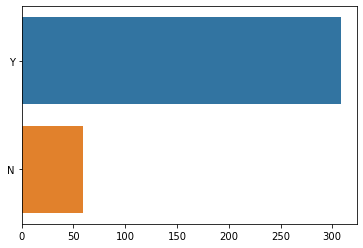

In [790]:
predict_featurs = pd.Series(predict).value_counts()

sns.barplot(predict_featurs.values, predict_featurs.index)